# ***AUTHORS***

## ***Clovis Lechien***


# ***TEAM NAME***

## ***Professional Gooner***

> * ***Seed Optimization***
>    1. Best Seed Search on 32 batch size
>    1. Best Seed Search on 64 batch size
    
> * ***Data Augmentation***
>     1. *RandomFlip* => Used in the final model
>     1. RandomRotation
>     1. *RandomZoom* => Used in the final model
>     1. *RandomContrast* => Used in the final model
>     1. RandomBrightness

> * ***Class Weights***
>     1. Train Dataset
>     1. Validation Dataset
>     1. Both Datasets fused => Used this one, thanks to my seed optimization from before the difference with using the train dataset one is minimal, so I can also improve a little bit on the validation set

> * ***Model Tuning***
>     1. Top Layer fine-tuning
>     1. Full Model fine-tuning
>     1. Optimal Dropout rate
>     1. Optimal Dense depths
>     1. Optimal Regularization methods

> * ***Hyperparameter tuning and training optimization***
>     1. Optimal learning rate search
>     1. Learning rate scheduler
>     1. Reduce LR on Plateau
>     1. Early Stopping
>     1. Checkpoints
>     1. Activation functions (relu, leakyrelu, ...)

> * ***Model Explainability***
>     1. Confusion Matrixes
>     1. Model History (accuracy, loss)

> * ***Archtectures tried but not kept***
>     1. Xception
>     1. EfficientNetB0
>     1. EfficientNetB1
>     1. EfficientNetB2
>     1. EfficientNetB3

In [3]:
# Quelques informations sur les données:

# TAILLE IMAGE : 128 x 192 x 3
# CATEGORIES:
# {'coastguard_scaled': 0, 'containership_scaled': 1, 'corvette_scaled': 2, 'cruiser_scaled': 3, 'cv_scaled': 4, 'destroyer_scaled': 5, 'methanier_scaled': 6, 'smallfish_scaled': 7, 'submarine_scaled': 8, 'tug_scaled': 9}

# Architecture:
# working/test.npy
# /working/ships_gray/{CATEGORY}/{IMAGE_ID}.jpg
# /working/ships_gray/...

# exemple: /working/ships_gray/coastguard_scaled/2414.jpg
# ID:
# 2414
# CATEGORY:
# coastguard_scaled : 0

In [4]:
!tar xzf /kaggle/input/navires-2024-libre/ships24.tgz

# **Imports**

#### Nous importons seulement les librairies qui nous seront utiles pour la suite:
1. ***Utils***: des librairies pour manipuler la données de manière générale.
2. ***Plotting***: des librairies pour visualiser et comprendre les données.
3. ***Dev QOL***: des librairies pour appliquer des techniques basiques pour améliorer la performance et la compréhension du modèle.
4. ***Model Creation***: équivoque
5. ***Model Optimization***: des librairies pour appliquer des techniques avancées d'optimisation du modèle, principalement durant l'entraînement.
6. ***Model Tuning***: deux librairies d'optimization et de recherche d'hyperparamètres pour améliorer les performances du modèle de manière significative.

In [5]:
# Utils
import os
import numpy as np
import pandas as pd
from typing import List, Tuple
import math

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Dev QOL
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# Model Creation
import keras
from keras import layers
from keras import regularizers

# Model Optimization
import tensorflow as tf
from tensorflow import data as tf_data
import tensorflow_decision_forests as tfdf
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

2024-05-30 19:16:58.300061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 19:16:58.300212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 19:16:58.462504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Creating the Dataframes**

#### Après recherche sur le jeu de données, nous déterminons que nos images sont de tailles (128, 192).

#### Nous décidons également d'importer les images par batch de taille 32, cette taille de batch sera également utilisée durant l'entraînement du modèle.

In [6]:
image_size = (128, 192)
batch_size = 32
best_seed = 154
num_classes = 10

Cette fonction sert à calculer la répartition des données dans chacune des 10 classes.

Elle a une seul utilité dans mon notebook:

1. ***Class Weight Computation***: Une méthode qui vise à équilibrer le poids des données pendant l'entraînement du modèle, dans un monde idéal nos 10 classes seraient répartis identiquement, or ce n'est pas le cas. Afin d'éviter que les classes sur représentés n'influent pas sur le modèle nous calculons des poids qui permettent de réguler leur influence.

En effet, dans le notebook sur la classification fait main j'ai déjà déterminé quelle était la meilleur seed d'import des données. \
Je n'ai donc pas besoin de le refaire ici.

In [7]:
# On récupère pour chaque classe du jeu de données (d'entraînement ou de validation) le nombre d'image 
def get_class_counts(df):
    class_counts_dict = {}
    
    for images, labels in df:
        label_indices = np.argmax(labels, axis=1)
        unique_classes, class_counts = np.unique(label_indices, return_counts=True)
        for cls, count in zip(unique_classes, class_counts):
            class_counts_dict[cls] = class_counts_dict.get(cls, 0) + count
    
    return class_counts_dict

In [8]:
df_train, df_vali = keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships_gray", # l'emplacement de nos données
    label_mode="categorical", # classification multi classes à 10 labels
    validation_split=0.2, # 80% des données servent à l'entraînement et 20% à la validation
    subset="both", # pour récupérer à la fois df_train et df_vali
    seed=best_seed, # notre meilleure seed d'import des données
    image_size=image_size, # la taille de nos images : (128 x 192)
    batch_size=batch_size, # la taille du batch d'import : 32
    color_mode="grayscale" # les images sont importées avec 1 seul channel de couleur : (128 x 192 x 1)
)

Found 42204 files belonging to 10 classes.
Using 33764 files for training.
Using 8440 files for validation.


# **Visualizing the Data**

In [9]:
class_distribution_train = pd.DataFrame.from_dict(get_class_counts(df_train), orient='index', columns=['train_count'])
class_distribution_train

,train_count
0,2770
1,5581
2,2383
3,5569
4,1614
5,5324
6,2800
7,2692
8,2276
9,2755


In [10]:
class_distribution_vali = pd.DataFrame.from_dict(get_class_counts(df_vali), orient='index', columns=['vali_count'])
class_distribution_vali

,vali_count
0,706
1,1382
2,591
3,1377
4,415
5,1322
6,725
7,657
8,571
9,694


In [11]:
class_names = ['coastguard_scaled', 'containership_scaled', 'corvette_scaled', 'cruiser_scaled', 'cv_scaled', 'destroyer_scaled', 'methanier_scaled', 'smallfish_scaled', 'submarine_scaled', 'tug_scaled']

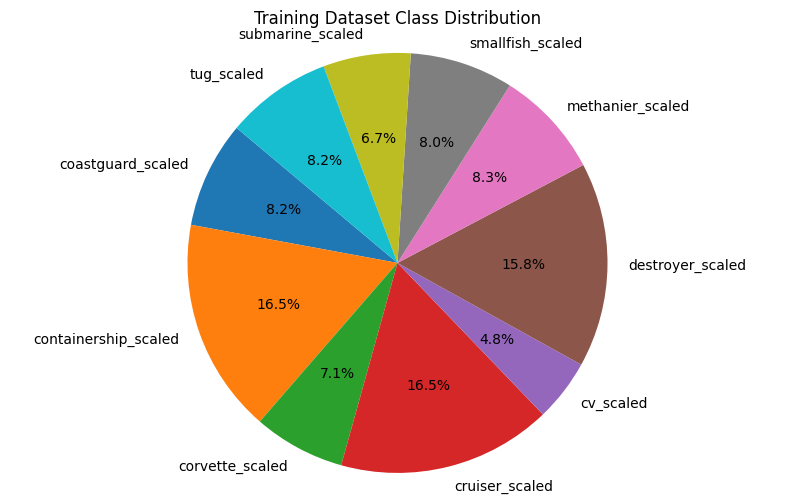

In [12]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_train['train_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Training Dataset Class Distribution')
plt.axis('equal')
plt.show()

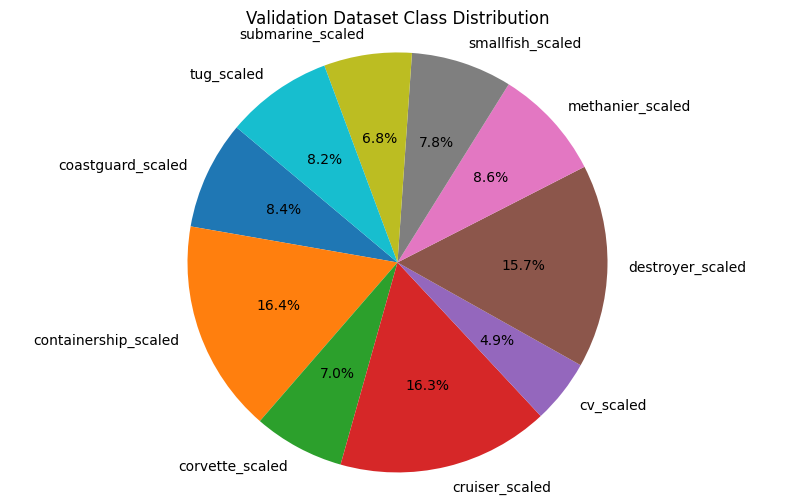

In [ ]:
plt.figure(figsize=(10, 6))
plt.pie(class_distribution_vali['vali_count'], labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Validation Dataset Class Distribution')
plt.axis('equal')
plt.show()

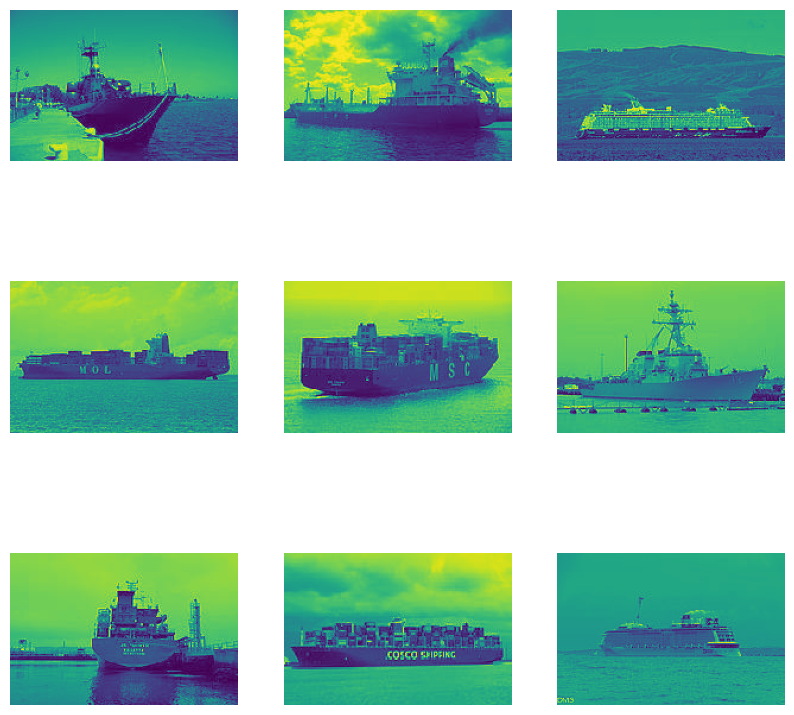

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.axis("off")

#### Ci-dessous j'ai affiché 2 images de bateau bien précis.

1. ***Un destroyer***
2. ***Une corvette***

#### En fait ces deux classes sont problématiques car les bateaux sont très similaires visuellement parlant, et la répartition des données montre un déséquilibre important.

#### Comme vu juste au dessus, on a en moyenne dans nos jeu de données d'entraînement/validation:

1. ***destroyer*** : 15.85% des images
2. ***corvette*** : 7.0% des images

#### Ce déséquilibre sera illustré plus tard dans le notebook avec la matrice de confusion du modèle après entraînement.

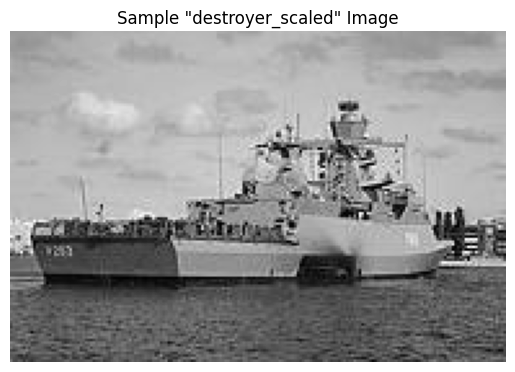

In [15]:
destroyer_scaled = 2

index = 0
for images, labels in df_train:
    if np.argmax(labels[0]) == destroyer_scaled:
        break
    index += 1

image = images[0].numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Sample "destroyer_scaled" Image')
plt.show()

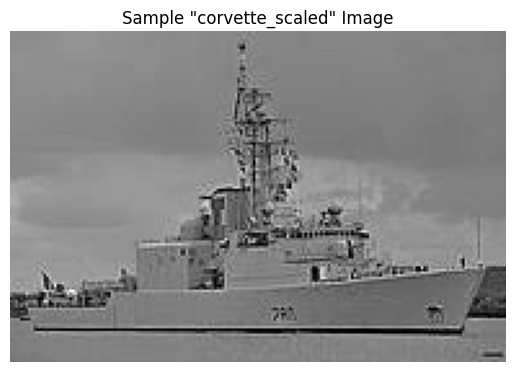

In [16]:
corvette_scaled = 5

index = 0
for images, labels in df_train:
    if np.argmax(labels[0]) == corvette_scaled:
        break
    index += 1

image = images[0].numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Sample "corvette_scaled" Image')
plt.show()

# **Fixing the class inbalances (using class weights)**

#### On va calculer ci-dessous les **"class weights"**, qui sont utilisées lors de l'entraînement du modèle pour atténuer le déséquilibre entre classes.

#### Pour se faire, on calcule celles des datasets d'entraînement et de validation, puis ont fait la moyenne des deux.

#### Comme nous nous sommes arrangés précédemment à trouver la meilleure seed d'import des données, la moyenne des deux datasets n'est pas loin ni de l'un ni de l'autre.

In [17]:
labels_list_train = []

for _, labels in df_train:
    labels_list_train.append(np.argmax(labels.numpy(), axis=1))

labels = np.concatenate(labels_list_train)

class_weights_train = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict_train = dict(enumerate(class_weights_train))
class_weight_dict_train

{0: 1.2189169675090252,
 1: 0.6049811861673535,
 2: 1.4168694922366765,
 3: 0.6062847908062489,
 4: 2.0919454770755888,
 5: 0.6341848234410218,
 6: 1.205857142857143,
 7: 1.2542347696879643,
 8: 1.4834797891036906,
 9: 1.2255535390199637}

In [18]:
labels_list_vali = []

for _, labels in df_vali:
    labels_list_vali.append(np.argmax(labels.numpy(), axis=1))

labels = np.concatenate(labels_list_vali)

class_weights_vali = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict_vali = dict(enumerate(class_weights_vali))
class_weight_dict_vali

{0: 1.1954674220963173,
 1: 0.6107091172214182,
 2: 1.428087986463621,
 3: 0.6129266521423384,
 4: 2.0337349397590363,
 5: 0.6384266263237519,
 6: 1.1641379310344828,
 7: 1.2846270928462709,
 8: 1.478108581436077,
 9: 1.2161383285302594}

In [19]:
class_weight_dict = {}

for key in class_weight_dict_train.keys():
    class_weight_dict[key] = (class_weight_dict_train[key] + class_weight_dict_vali[key]) / 2
    
class_weight_dict

{0: 1.2071921948026714,
 1: 0.6078451516943859,
 2: 1.4224787393501486,
 3: 0.6096057214742936,
 4: 2.0628402084173123,
 5: 0.6363057248823869,
 6: 1.1849975369458128,
 7: 1.2694309312671175,
 8: 1.4807941852698838,
 9: 1.2208459337751116}

# **Fixing the channels for fine tuning**

Les modèles disponibles sur Keras ont tous besoin d'images RGB, donc le fait d'avoir des images en grayscale ici est mauvais.

C'est pourquoi nous devons transformer nos images grayscaled en images RGB (à 3 channels de couleur).

In [20]:
def grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

df_train_rgb = df_train.map(grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)
df_vali_rgb = df_vali.map(grayscale_to_rgb, num_parallel_calls=tf.data.AUTOTUNE)

df_train = df_train_rgb.prefetch(buffer_size=tf.data.AUTOTUNE)
df_vali = df_vali_rgb.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
for images, labels in df_train.take(1):
    print(images.shape)

(32, 128, 192, 3)


# **Data Augmentation**

#### Dans cette partie on applique des filtres pour "augmenter les données".

#### Cela permet d'ajouter plus de diversité dans les images d'entraînement, sans pour autant impacter la répartition d'origine des données.

#### J'ai choisi de n'en appliquer que 3 sur les 6 disponibles ci-dessous car les résultats semblaient se déteriorer après une utilisation trop importante de ces filtres:
1. **RandomFlip**
1. **RandomZoom**
1. **RandomContrast**

In [22]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.0125),
    layers.RandomZoom(height_factor=0.0125, width_factor=0.0125),
    layers.RandomContrast(0.05),
#     layers.RandomCrop(height=128, width=192),
#     layers.RandomBrightness(0.025),
]

def data_augmentation(images, labels):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, labels

Voici quelques images après une data augmentation avec les filtres appliqués mentionnés précédemment:

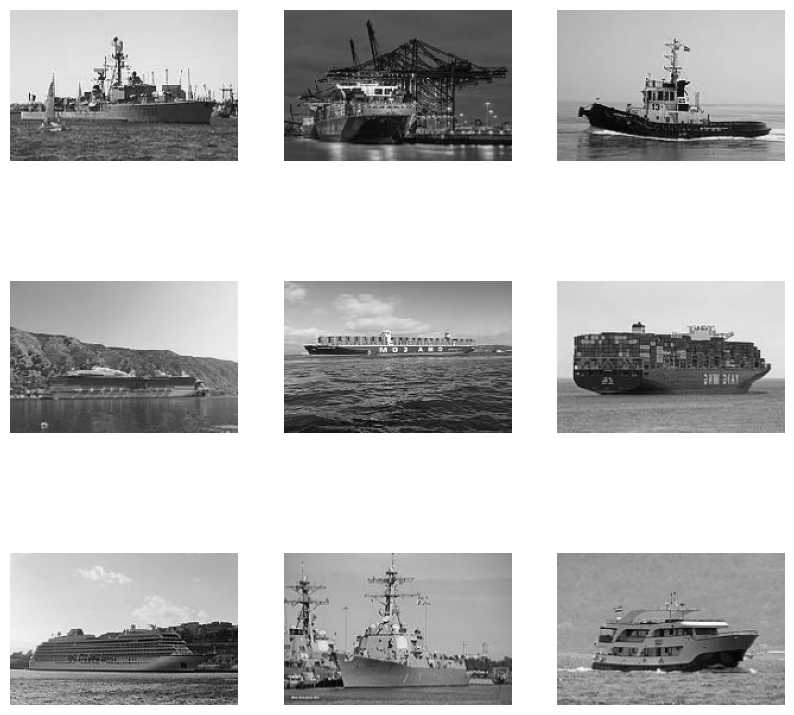

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in df_train.take(1):
    augmented_images, _ = data_augmentation(images, labels) # first transformation
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[i]).astype("uint8"))
        plt.axis("off")
plt.show()

In [24]:
# On augmente une fois nos données avec les 3 filtres.
# J'ai essayé d'augmenter plusieurs fois les données avec ces 3 filtres mais les résultats ne sont pas assez convaincants pour justifier l'opération.
for i in range(1):
    df_train = df_train.map(
        data_augmentation,
        num_parallel_calls=tf.data.AUTOTUNE
    )

# On "rescale" nos données: (0 - 255) -> (0 - 1)
# Cela facilite énormément la tâche d'apprentissage du modèle
normalization_layer = layers.Rescaling(1./255)

df_train = df_train.map(lambda x, y: (normalization_layer(x), y))
df_vali = df_vali.map(lambda x, y: (normalization_layer(x), y))

df_train = df_train.cache().shuffle(1).prefetch(tf_data.AUTOTUNE)
df_vali = df_vali.cache().prefetch(tf_data.AUTOTUNE)

# **Model**

Dans cette partie on définit l'architecture de notre modèle.

J'ai pu tester quelques architectures en complément d'un base model que je récupère sur Keras et j'ai retenu celle-ci, qui produit des résultats satisfaisants, généralement autour des 95% de validation accuracy en local.

Sur la submission cela se traduit à une précision d'environ 92,5%.

L'allure générale du modèle est un ***EfficientNetB4*** couplé à une succession de couches denses pour l'aider à affiner son choix de classification.

J'ai pu tester 5 autres modèles provenant de Keras, mais j'ai retenu ce-dernier qui donnait des résultats très intéressants pour un temps d'entraînement encore soutenable.

In [25]:
base_model = keras.applications.EfficientNetB4(
    weights='imagenet', # On importe le modèle pré entraîné sur le jeu de données ImageNet : https://www.image-net.org/
    input_shape=image_size + (3,),
    include_top=False # On ne garde pas les couches qui permettent de classifier les données, en effet on va créer les notres adaptées à notre jeu de données
)

base_model.trainable = False # On empêche dans un premier temps l'entraînement du base_model pour adapter les couches denses ui servent à classifier.

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
inputs = keras.Input(shape=image_size + (3,)) # la couche d'entrée du modèle, elle convertie si nécessaire les données en format utilisable par les couches suivantes.

x = base_model(inputs, training=False) # Notre base model, EfficientNetB4: (4, 6, 1792)

x = layers.GlobalAveragePooling2D()(x) # GlobalAveragePooling2D: (4, 6, 1792) -> 1792
x = layers.Dropout(0.5)(x) # 1er Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)

x = layers.Dense(1792, activation='relu')(x) # 1ère Couche Dense: 1792 -> 1792
x = layers.BatchNormalization()(x) # 1ère Couche de Normalisation: 1792 -> 1792
x = layers.Dropout(0.5)(x) # 2ème Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)

x = layers.Dense(1792, activation='relu')(x) # 2ème Couche Dense: 1792 -> 1792
x = layers.BatchNormalization()(x) # 2ème Couche de Normalisation: 1792 -> 1792
x = layers.Dropout(0.5)(x) # 3ème Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)

x = layers.Dense(896, activation='relu')(x) # 3ème Couche Dense: 1792 -> 896
x = layers.BatchNormalization()(x) # 3ème Couche de Normalisation: 896 -> 896
x = layers.Dropout(0.25)(x) # 4ème Dropout (25% des neurones sont désactivées entre la couche précedente et la suivante)

x = layers.Dense(896, activation='relu')(x) # 4ème Couche Dense: 896 -> 896
x = layers.BatchNormalization()(x) # 4ème Couche de Normalisation: 896 -> 896
x = layers.Dropout(0.25)(x) # 5ème Dropout (50% des neurones sont désactivées entre la couche précedente et la suivante)

x = layers.Dense(448, activation='relu')(x) # 5ème Couche Dense: 896 -> 448
x = layers.BatchNormalization()(x) # 5ème Couche de Normalisation: 448 -> 448
x = layers.Dropout(0.15)(x) # 6ème Dropout (15% des neurones sont désactivées entre la couche précedente et la suivante)

predictions = layers.Dense(num_classes, activation='softmax')(x) # 6ème Couche Dense: 448 -> 10 } nos 10 labels à classifier.

model = keras.Model(inputs, predictions, name='CNN_FineTuning_v7') # Au total, j'aurais essayé pas moins de 7 modèles avec des structures différentes.

L'hyperparamètre qui de loin influe le plus sur la qualité de l'entraînement du modèle est le ***learning rate***.

Après de nombreuses recherches sur ce-dernier, j'en suis arrivé à la conclusion que c'est un puits sans fond. \
On peut arriver à trouver une range où le learning rate sera correct mais les résultats ne seront jamais identiques.

Une valeur qui fonctionne bien cependant pour commencer l'entraînement dans mon cas est **2.5e-4** (trouvée grâce à optuna). \
Cela a été compliquée de trouver une valeur qui arrive à donner des résultats uniformes et satisfaisants.

In [27]:
initial_learning_rate = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate), # On utilise Adam comme optimizer pour notre modèle.
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

Voilà l'architecture complète du modèle, ainsi que son nombre de couches sans compter celles du base model, 20.

Cette visualisation du modèle a été utile pour déterminer les valeurs de sorties des modèles pré entrainés, et ainsi offrir une meilleure interface entre ces-derniers et mes couches pour classifier.

In [28]:
model.summary(show_trainable=True)

print("Nombre de couches : ", len(model.layers))

Model: "CNN_FineTuning_v7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 128, 192, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetb4 (Functional) │ (None, 4, 6, 1792)    │ 17,673,823 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 1792)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1792)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1792)          │  3,213,056 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization         │ (None, 1792)          │      7,168 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1792)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 1792)          │  3,213,056 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_1       │ (None, 1792)          │      7,168 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 1792)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 896)           │  1,606,528 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 896)           │      3,584 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 896)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 896)           │    803,712 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_3       │ (None, 896)           │      3,584 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 896)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 448)           │    401,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_4       │ (None, 448)           │      1,792 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_5 (Dropout)         │ (None, 448)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 10)            │      4,490 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 26,939,817 (102.77 MB)

 Trainable params: 9,254,346 (35.30 MB)

 Non-trainable params: 17,685,471 (67.46 MB)

Nombre de couches :  20


# **Model training**

Pour l'entraînement du modèle, j'ai pu tester tous les callbacks utiles à la problématique et disponible sur keras, \
ainsi que d'effectuer des recherches d'hyperparamètres sur ces-derniers pour optimiser leur utilisation.

J'en suis donc arrivé à ces valeurs.

In [29]:
epochs = 30 # nombre d'epochs total utilisé pour entraîner le modèle.
decay_rate = 1.069420 # taux d'évolution du learning par epoch pour LearningRateScheduler
min_lr = 1e-6 # valeur minimale du learning autorisée pour ReduceLROnPlateau et LearningRateScheduler
factor=0.2 # facteur de réduction du learning rate pour ReduceLROnPlateau
callbacks = [] # liste des callbacks à utiliser pendant l'entraînement

# Permet de sauvegarder tout au long de l'entraînement le meilleur modèle.
checkpoints = keras.callbacks.ModelCheckpoint(
    "save_at_{epoch}.keras", # nom du fichier
    monitor='val_categorical_accuracy', # la métrique à suivre pour comparer les modèles
    verbose=1,
    save_best_only=True, # permet de ne sauvegarder que le meilleur modèle
    mode='max' # on compare les métriques avec une fonction max
)

# La fonction qui permet de régir l'évolution du learning rate tout au long de l'entraînement.
def scheduler(epoch, lr):
    if epoch == 0 or lr <= min_lr :
        return lr
    if lr <= 1e-5 :
        return lr * decay_rate
    return lr


lr_schedule = LearningRateScheduler(scheduler)

# Permet de diminuer drastiquement le learning rate si le modèle a du mal à apprendre
reduceLR = ReduceLROnPlateau(
    monitor='val_categorical_accuracy', # la métrique à monitorer pour suivre l'évolution
    factor=factor, # on baisse le learning rate d'un certain facteur (0.2)
    patience=2, # On attend 2 epochs sans amélioration avant de baisser
    min_lr=min_lr, # on ne réduit pas le learning rate en dessous d'un certain seuil
    verbose=1,
)

# Permet d'arrêter l'entraînement prématurément si le modèle n'append plus depuis X epochs.
early_stop = EarlyStopping(
        monitor="val_categorical_accuracy", # la métrique à monitorer pour suivre l'évolution
        min_delta=1e-3, # on compare l'a précision à cette échelle : 0.00X 
        patience=7, # on attend 7 epochs sans évolution de la métrique avant d'arrêter le training
        verbose=1,
        mode='max', # on compare les métriques avec une fonction max
        restore_best_weights=True # si l'entraînement s'arrête on redonne à notre modèle ses meilleurs poids
)

callbacks.append(checkpoints)
callbacks.append(reduceLR)
callbacks.append(lr_schedule)
callbacks.append(early_stop)

On va diviser l'entraînement par bloc de 5 epochs.

Donc pour suivre correctement l'évolution du modèle on va d'ores et déjà définir notre dictionnaire qui va contenir les métriques de l'évolution de notre modèle tout au long de son entraînement.

In [30]:
history = {
    'loss': [],
    'val_loss': [],
    'categorical_accuracy': [],
    'val_categorical_accuracy': []
}

# ***Fine Tuning the top layers only***

Dans certains cas il est utile de démarrer l'entraînement d'un modèle sur un ou deux epochs afin de "réveiller" le GPU.

Ici, j'entraîne simplement le modèle sur un epoch, et je continue l'entraînement sur le reste des epochs.

On remarque une différence significative entre le temps d'éxecution du premier epoch et le temps d'éxecution des autres epochs.

Au delà de ça, on a précédemment instancié notre modèle sans autorisé l'apprentissage du base modèle.

Si l'on a fait cela c'est dans le but d'habituer seulement les tops layers sur notre jeu de données actuel.

On va le faire sur 1 epoch, puis on rendre l'intégralité du modèle "trainable" après.

In [ ]:
history_top = model.fit(
    df_train,
    epochs=1,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_top.history[key])

# ***Fine Tuning the entire model***

On va désormais rendre le modèle intégralement entraînable.

L'inférence a fait son job sur 1 epoch juste au-dessus, maintenant place aux choses sérieuses.

Comme mentionné précédemment on va scindé l'entraînement du modèle par groupe de 5 epochs.

Si j'ai fait cela c'était seulement dans le but de regarder plus finement l'évolution du modèle au travers de la matrice de confusion tous les 5 epochs.

In [ ]:
# =============== FIRST 10 epochs

In [ ]:
base_model.trainable = True
initial_learning_rate = 2.5e-4
initial_epoch = 0
epochs_parts = 10

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# =============== 15 epochs

In [ ]:
initial_epoch += epochs_parts
epochs_parts += 5

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# =============== 20 epochs

In [ ]:
initial_epoch += 5
epochs_parts += 5

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# =============== 25 epochs

In [ ]:
initial_epoch += 5
epochs_parts += 5

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# =============== 30 epochs

In [ ]:
initial_epoch += 5
epochs_parts += 5

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# =============== 35 epochs

In [ ]:
initial_epoch += 5
epochs_parts += 5

history_small = model.fit(
    df_train,
    epochs=epochs_parts,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    validation_data=df_vali,
    class_weight=class_weight_dict,
)

for key in history.keys():
    history[key].extend(history_small.history[key])

In [ ]:
# On sauvegarde notre modèle.
model.save('/kaggle/working/model.keras')

# ***Visualizing the results***

On commence par regarder l'évolution des métriques de notre modèle tout au long du training grâce à son historique d'entraînement.

Afin de mieux comprendre les résultats de notre modèle, on l'évalue sur le dataset de validation et on regarde les résultats sous forme d'une matrice de confusion.

Idéalement, on rechercherai à avoir une forte concentration des données sur la diagonale, symbolisant une classification correcte.

On repère cependant quelques points d'influence en dehors de cette diagonale, notamment entre les 2 classes problématiques citées précédemment.

In [ ]:
# On va regarder l'évolution du modèle durant l'entraînement.

def format_func(value, tick_number):
    return f'{value:.2f}'

train_accuracy = history['categorical_accuracy']
val_accuracy = history['val_categorical_accuracy']
train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

In [ ]:
# On regarde ensuite la matrice de confusion du modèle après évaluation sur le dataset de validation.

predictions = model.predict(df_vali)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([np.argmax(y, axis=1) for _, y in df_vali])

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# On remarque que les deux classes qui posent le plus problème sont les suivantes:
# corvette_scaled (#2) et destroyer_scaled (#5)

# ***Submission***

Enfin, on finit par soumettre nos résultats.

In [ ]:
x_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
x_test = x_test.astype('float32') / 255

res = model.predict(x_test).argmax(axis=1)

df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'reco_nav.csv')

In [ ]:
# On supprime les fichiers désormais inutiles une fois la procédure terminée.

!rm -rf /kaggle/working/ships_gray
!rm /kaggle/working/save_at_*.keras
!rm /kaggle/working/model.keras
!rm /kaggle/working/test.npy

# ***Bibliographie***

* https://keras.io/
* https://www.tensorflow.org/?hl=fr
* https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html#optuna.create_study
* https://keras.io/examples/vision/image_classification_from_scratch/
* https://www.tensorflow.org/guide/keras/serialization_and_saving
* https://www.cs.toronto.edu/~lczhang/321/tut/tut06.html
* https://github.com/maxim5/hyper-engine
* https://www.tensorflow.org/tutorials/images/classification?hl=fr
* https://www.kaggle.com/code/mishki/resnet-keras-code-from-scratch-train-on-gpu
* https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn
* https://stackoverflow.com/questions/61230762/with-resnet50-the-validation-accuracy-and-loss-is-not-changing
* https://www.kaggle.com/code/ilanguenet/iren-competition-1-louis-guo-et-ilan-guenet
* https://www.kaggle.com/code/basth94/comp-tition-navires-2023-la-mano-rbh/notebook
* https://stackoverflow.com/questions/37020754/how-to-increase-validation-accuracy-with-deep-neural-net
* https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# ***Je vous remercie pour votre lecture***

Comme vous avez pu vous en rendre compte, j'ai passé beaucoup de temps sur ce projet à me documenter, expérimenter, et améliorer mes démarches.

Entre cette compétition et celle fait main j'ai pu tester de nombreuses choses.

Je suis content du travail que j'ai produit et je sais que j'ai acquis de nombreuses compétences grâce à cette compétition.

- Clovis Lechien, ING2 [SCIA] - Epita 30/05/2024